# Bandwidth sensitivity in kernel smoothing

## Introduction

We consider the distribution

$$
f_1(x) = w_1 f_A(x) + w_2 f_B(x)
$$

for any $x\in\mathbb{R}$ where $f_A$ is the density of the Normal distribution 
$\mathcal{N}(0,1)$, $f_B$ is the density of the Normal distribution 
$\mathcal{N}(3/2,(1/3)^2)$ and the weights are $w_1 = \frac{3}{4}$ and $w_2 = \frac{1}{4}$.

This is a mixture of two Normal distributions: 1/4th of the observations have the $\mathcal{N}(0,1)$ 
distribution and 3/4th of the observations have the $\mathcal{N}(3/2,(1/3)^2)$ distribution. 
This example is considered in (Wand, Jones, 1994), page 14, Figure 2.3.

We consider a sample generated from independent realizations of $f_1$ and 
want to approximate the distribution from kernel smoothing. 
More precisely, we want to observe the sensitivity of the resulting density to the 
bandwidth.

## References

* "Kernel Smoothing", M.P.Wand, M.C.Jones. Chapman and Hall / CRC (1994).


## Generate the mixture by merging two samples

In this section, we show that a mixture of two Normal distributions is nothing more than the merged sample of two independent Normal distributions. In order to generate a sample with size $n$, we sample $\lfloor w_1 n\rfloor$ points from the first Normal distribution $f_A$ and $\lfloor w_2 n\rfloor$ points from the second Normal distribution $f_B$. Then we merge the two samples.

In [1]:
import openturns as ot
import openturns.viewer as otv
import pylab as pl
import numpy as np

We choose a rather large sample size: $n=1000$.

In [2]:
n = 1000

Then we define the two Normal distributions and their parameters. 

In [3]:
w1 = 0.75
w2 = 1.0 - w1
distribution1 = ot.Normal(0.0, 1.0)
distribution2 = ot.Normal(1.5, 1.0 / 3.0)

We generate two independent sub-samples from the two Normal distributions.

In [4]:
sample1 = distribution1.getSample(int(w1 * n))
sample2 = distribution2.getSample(int(w2 * n))

Then we merge the sub-samples into a larger one with the `add` method of the `Sample` class. 

In [5]:
sample = ot.Sample(sample1)
sample.add(sample2)
sample.getSize()

1000

In order to see the result, we build a kernel smoothing approximation on the sample. In order to keep it simple, let us use the default bandwidth selection rule.

In [6]:
factory = ot.KernelSmoothing()
fit = factory.build(sample)

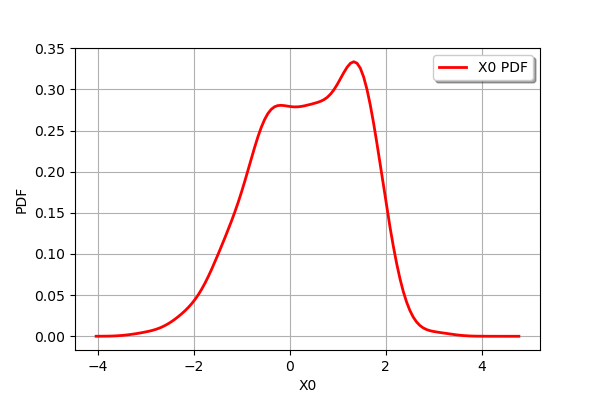

In [7]:
fit.drawPDF()

We see that the distribution of the merged sample has two modes. However, these modes are not clearly distinct. To distinguish them, we could increase the sample size. However, it might be interesting to see if the bandwidth selection rule can be better chosen: this is the purpose of the next section.

## Simulation based on a mixture

Since the distribution that we approximate is a mixture, it will be more convenient to create it from the `Mixture` class. It takes as input argument a list of distributions and a list of weights. 

In [8]:
distribution = ot.Mixture([distribution1, distribution2], [w1, w2])

Then we generate a sample from it. 

In [9]:
sample = distribution.getSample(n)

In [10]:
factory = ot.KernelSmoothing()
fit = factory.build(sample)

In [11]:
factory.getBandwidth()

class=Point name=Unnamed dimension=1 values=[0.172231]

We see that the default bandwidth is close to 0.17.

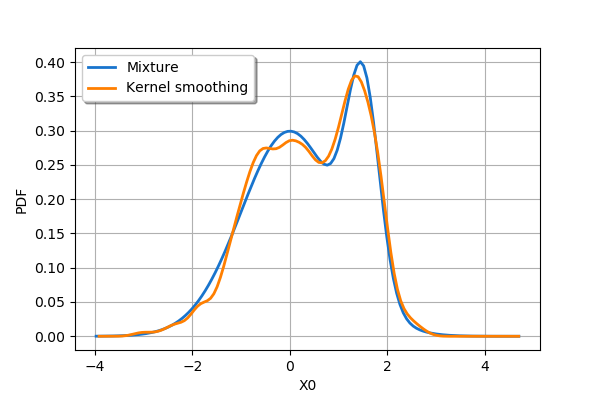

In [12]:
graph = distribution.drawPDF()
curve = fit.drawPDF()
graph.add(curve)
graph.setColors(["dodgerblue3", "darkorange1"])
graph.setLegends(["Mixture", "Kernel smoothing"])
graph.setLegendPosition("topleft")
graph

We see that the result of the kernel smoothing approximation of the mixture is similar to the previous one and could be improved.

## Sensitivity to the bandwidth

In this section, we observe the sensitivity of the kernel smoothing to the bandwidth. We consider the three following bandwidths: the small bandwidth 0.05, the large bandwidth 0.54 and 0.18 which is in-between. For each bandwidth, we use the second optional argument of the `build` method in order to select a specific bandwidth value. 

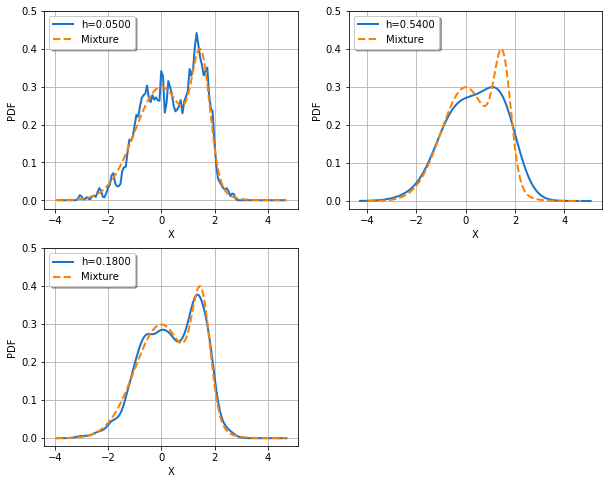

In [13]:
hArray = [0.05, 0.54, 0.18]
nLen = len(hArray)
fig = pl.figure(figsize=(10, 8))
for i in range(nLen):
    ax = fig.add_subplot(2, 2, i + 1)
    fit = factory.build(sample, [hArray[i]])
    graph = fit.drawPDF()
    graph.setColors(["dodgerblue3"])
    graph.setLegends(["h=%.4f" % (hArray[i])])
    exact = distribution.drawPDF()
    curve = exact.getDrawable(0)
    curve.setColor("darkorange1")
    curve.setLegend("Mixture")
    curve.setLineStyle("dashed")
    graph.add(curve)
    graph.setLegendPosition("topleft")
    graph.setXTitle("X")
    view = otv.View(graph, figure=fig, axes=[ax])
    pl.ylim(top = 0.5)  # Common y-range

We see that when the bandwidth is too low, then the resulting kernel smoothing has many more modes than the distribution it is supposed to approximate. When the bandwidth is too large, then the approximated distribution is too smooth and has only one mode instead of the expected two modes which are in the mixture distribution. When the bandwidth is equal to 0.18, then the two modes are correctly represented.

## Sensitivity to the bandwidth rule

The library provides three different rules to compute the bandwidth. In this section, we compare the results that we can get with them. 

In [14]:
h1 = factory.computeSilvermanBandwidth(sample)[0]
h1

0.32485720385649985

In [15]:
h2 = factory.computePluginBandwidth(sample)[0]
h2

0.1848718402032365

In [16]:
h3 = factory.computeMixedBandwidth(sample)[0]
h3

0.17223149346426894

In [17]:
factory.getBandwidth()[0]

0.18

We see that the default rule is the "Mixed" rule. This is because the sample is in dimension 1 and the sample size is quite large. For a small sample in 1 dimension, the "Plugin" rule would have been used.

The following script compares the results produced by the three rules.

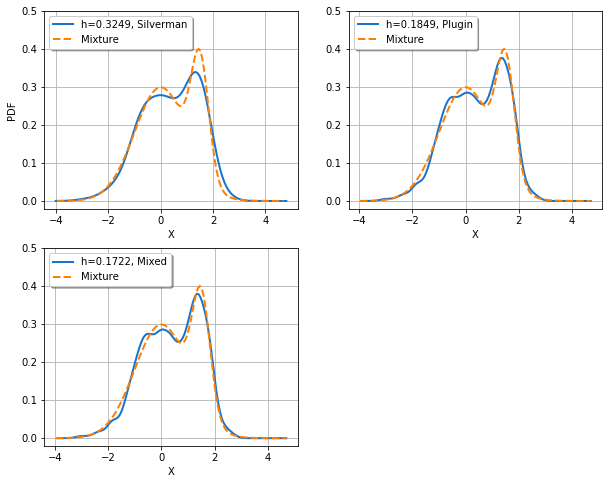

In [18]:
hArray = [h1, h2, h3]
legends = ["Silverman", "Plugin", "Mixed"]
nLen = len(hArray)
fig = pl.figure(figsize=(10, 8))
for i in range(nLen):
    ax = fig.add_subplot(2, 2, i + 1)
    fit = factory.build(sample, [hArray[i]])
    graph = fit.drawPDF()
    graph.setColors(["dodgerblue3"])
    graph.setLegends(["h=%.4f, %s" % (hArray[i], legends[i])])
    exact = distribution.drawPDF()
    curve = exact.getDrawable(0)
    curve.setColor("darkorange1")
    curve.setLegend("Mixture")
    curve.setLineStyle("dashed")
    graph.add(curve)
    graph.setLegendPosition("topleft")
    graph.setXTitle("X")
    if i > 0:
        graph.setYTitle("")
    view = otv.View(graph, figure=fig, axes=[ax])
    pl.ylim(top = 0.5)  # Common y-range

We see that the bandwidth produced by Silverman's rule is too large, leading to an oversmoothed distribution. The results produced by the Plugin and Mixed rules are comparable in this case.